<a href="https://colab.research.google.com/github/cawcawlabs/ouster_lidar_appnotes/blob/presentation_touch_up/Ouster_Open3d_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://data.ouster.io/sdk-samples/Rev-05/OS1-128_Rev-05_Urban-Drive/OS1-128_Rev-05_Urban-Drive.zip

!unzip /content/OS1-128_Rev-05_Urban-Drive.zip

!wget https://storage.googleapis.com/data.ouster.io/concept-engineering/colab_images/spezia.npy

In [ ]:
!pip install 'ouster-sdk'

In [ ]:
!pip install open3d

In [ ]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
from ouster import client

from ouster import pcap
from contextlib import closing
from more_itertools import nth

In [ ]:
pcap_path = '/content/OS1-128_Rev-05_Urban-Drive.pcap'
metadata_path = '/content/OS1-128_Rev-05_Urban-Drive.json'


with open(metadata_path, 'r') as f:
    info = client.SensorInfo(f.read())

source = pcap.Pcap(pcap_path, info)

with closing(client.Scans(source)) as scans:
    scan = nth(scans, 50)
range_field = scan.field(client.ChanField.RANGE)
range_img = client.destagger(info, range_field)

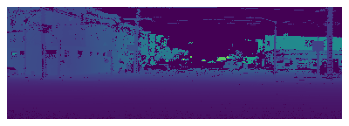

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(range_img[:, 640:1024], resample=False)
plt.axis('off')
plt.show()

In [ ]:
def draw(geometries):
    graph_obj = []

    for gm in geometries:
        geometry_type = gm.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            pts = np.asarray(gm.points)
            clr = None  #for colors
            if gm.has_colors():
                clr = np.asarray(gm.colors)
            elif gm.has_normals():
                clr = (0.5, 0.5, 0.5) + np.asarray(gm.normals) * 0.5
            else:
                gm.paint_uniform_color((1.0, 0.0, 0.0))
                clr = np.asarray(gm.colors)

            sc = go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], mode='markers', marker=dict(size=1, color=clr))
            graph_obj.append(sc)
        
    fig = go.Figure(
        data=graph_obj,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                #dsohn
                aspectmode='data'
            )
        )
    )
    fig.update_layout(paper_bgcolor="black")
    fig.show()

In [ ]:
def colorize(image: np.ndarray):
    """Use Ouster spezia colormap to get from gray to color space.
    Args:
        image: 2D array of values in the range [0, 1]
    Returns:
        Array of RGB values of the same dimension selected from the color map
    """
    key_img_indices = (255 * image).astype(np.uint8)
    return np.reshape(np.take(spezia, key_img_indices.flat, axis=0),
                      [image.shape[0], image.shape[1], 3])

spezia = np.load('/content/spezia.npy')

In [ ]:
# compute point cloud using client.SensorInfo and client.LidarScan

xyz = client.XYZLut(info)(scan)

# create point cloud and coordinate axes geometries

cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz.reshape((-1, 3))))  # type: ignore
field_ind = 2
fields = list(scan.fields)
key = scan.field(fields[field_ind]).astype(float)
color_img = colorize(key)
cloud.colors = o3d.utility.Vector3dVector(color_img.reshape((-1, 3)))

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(1.0)  # type: ignore


In [ ]:
o3d.visualization.draw_geometries = draw # replace function
o3d.visualization.draw_geometries([cloud,axes])


![picture](https://storage.googleapis.com/data.ouster.io/concept-engineering/colab_images/newplot.png)

